In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

print(xx.shape)
print(yy.shape)

(40000, 4)
(40000, 88)


In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5])
lb=np.array([0.01,0.3,-0.95,0.025])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =32,shuffle=True)

device is cuda


In [3]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import NN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':4,'hidden_dim':30,'hidden_nums':3,'output_dim':88}

model = NN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.8165179919493339
test loss is 1.026614594324548
Batch: 100,train loss is: 1.2792929852189585
test loss is 1.0178913998861236
Batch: 200,train loss is: 1.146716537870494
test loss is 1.0135905234596998
Batch: 300,train loss is: 0.8785418172921032
test loss is 1.0111293198667113
Batch: 400,train loss is: 0.9912842016050234
test loss is 1.0099817842267094
Batch: 500,train loss is: 0.7009373024760694
test loss is 0.9965372522777214
Batch: 600,train loss is: 0.5141768598945013
test loss is 0.5992225924793243
Batch: 700,train loss is: 0.5701558164963036
test loss is 0.5692030129772921
Batch: 800,train loss is: 0.5647011157975484
test loss is 0.5062327575244199
Batch: 900,train loss is: 0.48234201213583977
test loss is 0.4905303004443471
Batch: 1000,train loss is: 0.38820306418055406
test loss is 0.4464707489497428
-----------------------Epoch: 1----------------------------------
Batch: 0,train loss is

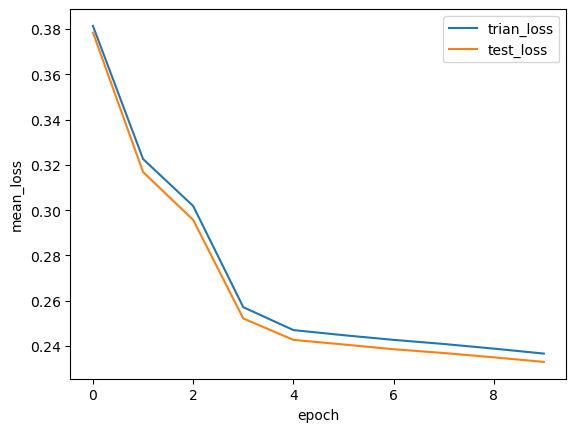

In [4]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.27410946972485545
test loss is 0.23298257203678832
Batch: 100,train loss is: 0.24679142214544916
test loss is 0.23262026520925969
Batch: 200,train loss is: 0.27364101064640095
test loss is 0.232450808512549
Batch: 300,train loss is: 0.26265355978343996
test loss is 0.23230593965547
Batch: 400,train loss is: 0.22916523004263434
test loss is 0.23226347852201285
Batch: 500,train loss is: 0.2332759229077429
test loss is 0.23228034743114254
Batch: 600,train loss is: 0.24966169625100668
test loss is 0.23226273207678733
Batch: 700,train loss is: 0.23982819623557317
test loss is 0.23217040832844427
Batch: 800,train loss is: 0.18005717796943138
test loss is 0.23217134512923426
Batch: 900,train loss is: 0.21255495778864697
test loss is 0.23207910323202496
Batch: 1000,train loss is: 0.21946525205883505
test loss is 0.2320692052894749
-----------------------Epoch: 1----------------------------------
Batch: 

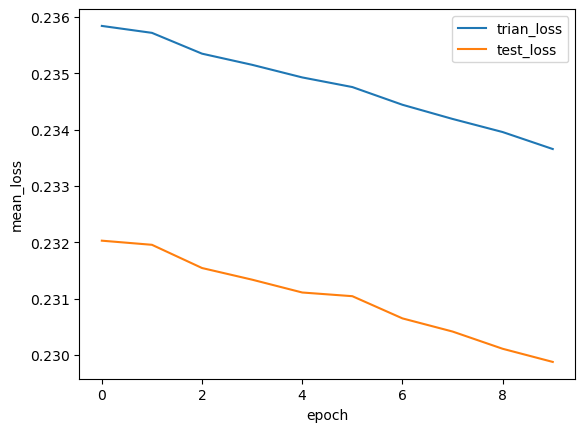

In [5]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

In [6]:
torch.save(model.state_dict(),'../../Data/YU/rflatBergomi_initial.pth')